In [1]:
# Source: Alexandru Tifrea and Fanny Yang, 2021.

# Python Notebook Commands
%reload_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import HTML
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

from copy import deepcopy

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from scipy.optimize import line_search

import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
plotly.offline.init_notebook_mode()

# TODO: use plotly instead of matplotlib.
import matplotlib.pyplot as plt
import autograd.numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation, rc

# TODO: use jax instead of autograd.
from autograd import elementwise_grad
from scipy.optimize import minimize, OptimizeResult, fmin
from collections import defaultdict
from itertools import zip_longest, product
from functools import partial

import ipywidgets
from ipywidgets import interact, interactive, interact_manual

from optimization_utils import TrajectoryAnimation, TrajectoryAnimation3D

# Change these values if the images don't fit for your screen.
figure_width = 12
figure_height = 12

colors = ["purple", "blue", "black", "green", "cyan", "orange"]
markers = ["o", "v", "+", "^", "s"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/8z/h732mzmx1g36_qdfvy0t3vt80000gn/T/ipykernel_4042/1047774664.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Convergence of gradient descent to the max-margin solution

In [2]:
def load_toy_data(seed=None):
    # Generate samples for one of the two classes, by drawing them from a Gaussian distribution.
    def gen_one_class(mean, Sigma_diag=None, dim=2, num_points=20):
        mean = np.array(mean)
        x = np.random.normal(size=(num_points, dim))
        x = mean + x @ np.diag(np.sqrt(Sigma_diag))
        return x

    np.random.seed(seed)
    num_points = 200

    mean = np.array([0, 0.5])
    Sigma_diag = np.array([1, 0.01])

    # Create the labeled set.
    mean_offset = 0.
    x = np.concatenate((gen_one_class(mean=mean_offset - mean,
                                      Sigma_diag=Sigma_diag,
                                      dim=2,
                                      num_points=num_points // 2),
                        gen_one_class(mean=mean_offset + mean,
                                      Sigma_diag=Sigma_diag,
                                      dim=2,
                                      num_points=num_points // 2)),
                       axis=0)

    # Split the labeled set into training and test splits.
    y = np.concatenate(
        (np.zeros(num_points // 2), np.ones(num_points // 2))).reshape(-1)
    idx = np.random.permutation(num_points)
    x, y = x[idx], y[idx]
    x_train, y_train = x[:num_points // 2], y[:num_points // 2]
    x_test, y_test = x[num_points // 2:], y[num_points // 2:]
    return x_train, y_train, x_test, y_test

In [3]:
def show_gd_animation():
    # Train logistic regression using gradient descent.
    x_train, y_train, x_test, y_test = load_toy_data(seed=2)
    clf = SGDClassifier(max_iter=1,
                        fit_intercept=True,
                        tol=None,
                        loss="log",
                        learning_rate="constant",
                        eta0=0.001)
    num_epochs = 100
    Ws, bs = [], []
    for i in range(num_epochs):
        # Before the first epoch, initialize the parameters of the logistic regression model.
        # Otherwise, we use the parameter values from the previous epoch.
        if i == 0:
            coef_init, intercept_init = [0.1, 0.1], 0.
            Ws.append(coef_init)
            bs.append([intercept_init])
        else:
            coef_init, intercept_init = Ws[-1], bs[-1]
        clf.fit(x_train,
                y_train,
                coef_init=coef_init,
                intercept_init=intercept_init)
        Ws.append(clf.coef_[0])
        bs.append(clf.intercept_)

    # Get maximum margin classifier, for comparison.
    svc = SVC(C=1000, kernel='linear')
    svc.fit(x_train, y_train)

    # Plots a linear function determined by a slope and an intercept term passed as arguments.
    def plot_decision_boundary(W, b, name="", color=None):
        x1 = np.linspace(-10, 10, 100)
        x2 = (-b[0] - W[0] * x1) / W[1]
        return go.Scatter(x=x1,
                          y=x2,
                          line=dict(color=color, width=3),
                          mode="lines",
                          name=name)

    # Create animation.
    x0, x1 = x_train[y_train == 0], x_train[y_train == 1]
    fig = go.Figure(
        data=[
            plot_decision_boundary(Ws[0],
                                   bs[0],
                                   "Classifier trained with GD",
                                   color="orange"),
            plot_decision_boundary(svc.coef_[0],
                                   svc.intercept_,
                                   "Max. margin classifier",
                                   color="black"),
            go.Scatter(x=x0[:, 0],
                       y=x0[:, 1],
                       mode="markers",
                       marker_symbol="circle",
                       marker_color="red",
                       marker_size=9,
                       name="Samples from class 0"),
            go.Scatter(x=x1[:, 0],
                       y=x1[:, 1],
                       mode="markers",
                       marker_symbol="cross",
                       marker_color="blue",
                       marker_size=9,
                       name="Samples from class 1"),
        ],
        frames=[
            go.Frame(data=[
                plot_decision_boundary(Ws[epoch],
                                       bs[epoch],
                                       "Gradient descent classifier",
                                       color="orange")
            ]) for epoch in range(num_epochs)
        ])

    fig.update_layout(width=850,
                      height=700,
                      xaxis_tickvals=np.arange(-2, 2.1, 0.5),
                      yaxis_tickvals=np.arange(-2, 2.1, 0.5),
                      xaxis_range=[-2, 2],
                      yaxis_range=[-2, 2],
                      updatemenus=[
                          dict(type="buttons",
                               buttons=[
                                   dict(label="Play",
                                        method="animate",
                                        args=[
                                            None, {
                                                "frame": {
                                                    "duration": 2500,
                                                    "redraw": False
                                                },
                                                "fromcurrent": True,
                                                "transition": {
                                                    "duration": 2500,
                                                    "easing": "linear"
                                                }
                                            }
                                        ]),
                                   dict(label="Pause",
                                        method="animate",
                                        args=[[None], {
                                            "frame": {
                                                "duration": 0,
                                                "redraw": False
                                            },
                                            "mode": "immediate",
                                            "transition": {
                                                "duration": 0
                                            }
                                        }]),
                               ])
                      ])
    fig.show()


_ = interact_manual(show_gd_animation)

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

# Impact of some hyperparameters on the optimization path

In [4]:
beta1_min, beta1_max, beta1_step = -4., 6.5, .2
beta2_min, beta2_max, beta2_step = -4., 6.5, .2


def init_optimization_problem(l2_coef=0., condition_number=1.):
    d = 2
    n = 100
    noise_sigma = 0.
    np.random.seed(42)

    # Draw samples from a standard Gaussian.
    X = np.random.normal(size=(n, d))

    # Make sure the condition number of the sample covariance matrix, i.e. 1/n * X^T @ X, is set as
    # the value passed as parameter.
    U, s, Vt = np.linalg.svd(X / np.sqrt(n))
    old_s_norm = np.linalg.norm(s)
    s = np.array([1., np.sqrt(1. / condition_number)])
    s = s / np.linalg.norm(s) * old_s_norm
    X = np.dot(U[:, :2] * s, Vt)

    # Compute the eigenvalues of the sample covariance matrix 1/n * (X.T @ X) and confirm that
    # the condition number is indeed equal to the value passed as parameter.
    empirical_spectrum = np.linalg.eig(1. / n * X.T @ X)[0]
    assert np.fabs(condition_number -
                   empirical_spectrum[1] / empirical_spectrum[0]) < 1e-5

    # Generate the values of the predictor variable y, starting from a ground truth function
    # determined by beta_star.
    beta_star = np.array([1., 3.]).reshape(-1, 1)
    y = (X @ beta_star).reshape(
        n, 1) + np.random.normal(size=(n, 1)) * noise_sigma

    # Define the loss function for a given set of parameters beta.
    def f(beta):
        _beta = beta.reshape(-1, 2)
        mse = ((X @ _beta.T - y)**2).mean(axis=0).reshape(-1)
        l2_reg = np.linalg.norm(_beta, axis=1).reshape(-1)**2
        return (mse + l2_coef * l2_reg) / 2

    # Define the derivative of the loss function wrt parameters beta.
    gradf = lambda beta: elementwise_grad(f)(beta)

    # Compute an approximation of the global minimum of the loss function wrt parameters beta.
    global_minimum = fmin(func=f, x0=[0, 0], full_output=False, disp=False)

    # Get function values for a grid for plotting purposes.
    beta1, beta2 = np.meshgrid(
        np.arange(beta1_min, beta1_max + beta1_step, beta1_step),
        np.arange(beta2_min, beta2_max + beta2_step, beta2_step))
    z = f(np.array(list(zip(beta1.reshape(-1),
                            beta2.reshape(-1))))).reshape(beta1.shape)
    return {
        "f": f,
        "gradf": gradf,
        "beta1": beta1,
        "beta2": beta2,
        "z": z,
        "global_minimum": global_minimum,
        "empirical_spectrum": empirical_spectrum,
    }

### Loss landscape

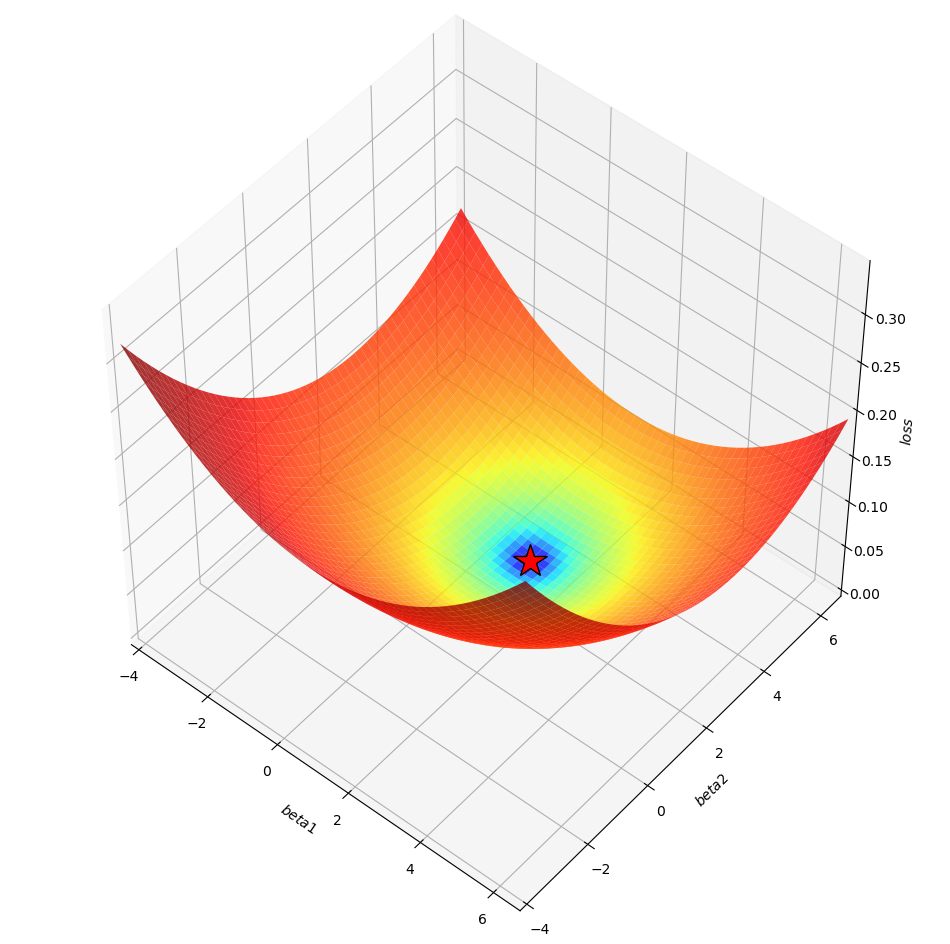

In [ ]:
opt_pb = init_optimization_problem(l2_coef=0.)
beta1, beta2, z = opt_pb["beta1"], opt_pb["beta2"], opt_pb["z"]
f, global_minimum = opt_pb["f"], opt_pb["global_minimum"]

fig = plt.figure(figsize=(figure_width, figure_height))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(beta1,
                beta2,
                z,
                norm=LogNorm(),
                rstride=1,
                cstride=1,
                edgecolor='none',
                alpha=.8,
                cmap=plt.cm.jet)
ax.plot([global_minimum[0]], [global_minimum[1]],
        f(global_minimum),
        'r*',
        markersize=25,
        markeredgecolor="black",
        color="red",
        zorder=10)

ax.set_xlabel('$beta1$')
ax.set_ylabel('$beta2$')
ax.set_zlabel('$loss$')

ax.set_xlim((beta1_min, beta1_max))
ax.set_ylim((beta2_min, beta2_max))

plt.show()

### Gradient descent optimization path

In the following plots we show how the optimization path changes with the learning rate, the condition number of the data matrix or the ridge coefficient.

In [6]:
"""
Get the optimization path for a problem determined by the argument opt_pb.
The function can return the optimization paths obtained with a list of optimization algorithms,
passed as argument.
Each method in the methods list is a string with the following regex format:
'GD .*lr=[0-9]*.[0-9]*'
"""


def get_optimization_path(opt_pb, methods):
    # Pick initial values for the parameters.
    beta0 = np.array([-2., 4.])
    f, gradf = opt_pb["f"], opt_pb["gradf"]

    # Use the scipy minimize API to compute the steps of gradient descent.
    minimize_ = partial(minimize,
                        fun=f,
                        x0=beta0,
                        jac=gradf,
                        bounds=[(beta1_min, beta1_max),
                                (beta2_min, beta2_max)],
                        tol=1e-20)

    # Utility function that collects the points along the optimization path.
    def make_minimize_callback(path=[]):
        def minimize_callback(xk):
            path.append(np.copy(xk))

        return minimize_callback

    # Instantiate the optimization algorithm for each of the methods.
    update_function = {}
    for method in methods:
        lr = float(method.rsplit("=", 1)[-1])
        update_function[method] = partial(gradient_descent, learning_rate=lr)

    # Run all the optimization algorithms and extract the path for each of them.
    paths_ = defaultdict(list)
    results = {
        method: minimize_(method=update_function[method],
                          callback=make_minimize_callback(paths_[method]))
        for method in methods
    }

    paths = [np.array(paths_[method]).T for method in methods]
    zpaths = [f(path) for path in paths]
    return paths, zpaths


"""
Perform maxiter steps of gradient descent. The objective function is passed as
argument (i.e. func) together with a callable that computes the gradient of the
objective function wrt to the parameters we want to optimize (i.e. jac).
The function is implemented to comply with the requirements of the scipy minimize API.
"""


def gradient_descent(func,
                     x0,
                     jac,
                     args=(),
                     learning_rate=0.1,
                     maxiter=20,
                     callback=None,
                     **kwargs):
    x = x0
    for i in range(maxiter):
        g = jac(x)
        if callback and callback(x):
            break
        x = x - learning_rate * g

    return OptimizeResult(x=x,
                          fun=func(x),
                          jac=jac(x),
                          nit=maxiter + 1,
                          nfev=maxiter + 1,
                          success=True)


def show_animation(paths, zpaths, methods, opt_pb, plot_type="2D"):
    beta1, beta2, z = opt_pb["beta1"], opt_pb["beta2"], opt_pb["z"]
    f, global_minimum = opt_pb["f"], opt_pb["global_minimum"]

    fig, ax = plt.subplots(figsize=(figure_width, figure_height))
    interval = 300

    if plot_type == "2D":
        ax.contour(beta1,
                   beta2,
                   z,
                   levels=np.logspace(-2, 2, 35),
                   norm=LogNorm(),
                   cmap=plt.cm.jet)
        ax.plot([global_minimum[0]], [global_minimum[1]],
                'r*',
                markersize=30,
                markeredgecolor="black",
                color="red",
                zorder=10)

        ax.set_xlabel('$beta1$')
        ax.set_ylabel('$beta2$')
        ax.set_xlim((beta1_min, beta1_max))
        ax.set_ylim((beta2_min, beta2_max))

        anim = TrajectoryAnimation(*paths,
                                   colors=colors,
                                   markers=markers,
                                   interval=interval,
                                   labels=methods,
                                   ax=ax)
    elif plot_type == "3D":
        ax = plt.axes(projection='3d', elev=50, azim=-50)
        ax.plot_surface(beta1,
                        beta2,
                        z,
                        norm=LogNorm(),
                        rstride=1,
                        cstride=1,
                        edgecolor='none',
                        alpha=.8,
                        cmap=plt.cm.jet)
        ax.plot([global_minimum[0]], [global_minimum[1]],
                f(global_minimum),
                'r*',
                markersize=30,
                markeredgecolor="black",
                color="red",
                zorder=10)

        ax.set_xlabel('$beta1$')
        ax.set_ylabel('$beta2$')
        ax.set_zlabel('$loss$')
        ax.set_xlim((beta1_min, beta1_max))
        ax.set_ylim((beta2_min, beta2_max))

        anim = TrajectoryAnimation3D(*paths,
                                     zpaths=zpaths,
                                     colors=colors,
                                     markers=markers,
                                     interval=interval,
                                     labels=methods,
                                     ax=ax)
    else:
        raise RuntimeError(
            f"Unrecognized plot type {plot_type}. Should be one of '2D' or '3D'"
        )

    plt.close()
    ax.legend(loc='upper left')
    return anim


def show_animation_wrapper(plot_type="2D",
                           learning_rate=None,
                           l2_coef=0.,
                           condition_number=1.):
    opt_pb = init_optimization_problem(l2_coef=l2_coef,
                                       condition_number=condition_number)

    methods = []
    if learning_rate == "show all options":
        lr = 2. / (np.max(opt_pb["empirical_spectrum"]) + l2_coef)
        methods.append(f"GD limit lr={lr:.3f}")
    if learning_rate in ["small", "show all options"]:
        lr = 0.01
        methods.append(f"GD lr={lr:.3f}")
    if learning_rate in ["moderate", "show all options"]:
        lr = 0.1
        methods.append(f"GD lr={lr:.3f}")
    if learning_rate in ["large", "show all options"]:
        lr = 0.9
        methods.append(f"GD lr={lr:.3f}")
    if learning_rate in ["optimal", "show all options"]:
        lr = 2. / (opt_pb["empirical_spectrum"].sum() + 2 * l2_coef)
        methods.append(f"GD optimal lr={lr:.3f}")

    paths, zpaths = get_optimization_path(opt_pb=opt_pb, methods=methods)
    anim = show_animation(paths=paths,
                          zpaths=zpaths,
                          methods=methods,
                          opt_pb=opt_pb,
                          plot_type=plot_type)
    display(HTML(anim.to_jshtml()))

In [7]:
plot_type = ipywidgets.Dropdown(options=["2D", "3D"],
                                value="2D",
                                description='Plot type:',
                                disabled=False,
                                style={'description_width': 'initial'},
                                continuous_update=True)
learning_rate = ipywidgets.Dropdown(
    options=["small", "moderate", "large", "optimal", "show all options"],
    value="show all options",
    description='Learning rate:',
    disabled=False,
    style={'description_width': 'initial'},
    continuous_update=True)
l2_coef = ipywidgets.FloatSlider(min=0,
                                 max=1,
                                 step=0.1,
                                 value=0.,
                                 readout_format='.1f',
                                 description='Ridge coefficient:',
                                 style={'description_width': 'initial'},
                                 continuous_update=False)
condition_number = ipywidgets.FloatSlider(
    min=1,
    max=5,
    step=1.,
    value=1.,
    readout_format='.1f',
    description='Condition number:',
    style={'description_width': 'initial'},
    continuous_update=False)

_ = interact_manual(show_animation_wrapper,
                    plot_type=plot_type,
                    learning_rate=learning_rate,
                    l2_coef=l2_coef,
                    condition_number=condition_number)

interactive(children=(Dropdown(description='Plot type:', options=('2D', '3D'), style=DescriptionStyle(descript…